# **0. 환경 설정**

In [199]:
# 라이브러리 설치
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import calendar
from sqlalchemy import create_engine
from urllib.parse import quote_plus

In [203]:
# 폰트 설정 (한글 깨짐 방지)
# macOS
#plt.rcParams['font.family'] = 'AppleGothic'

# Windows
plt.rcParams['font.family'] = 'Malgun Gothic'

# "-" 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

In [33]:
# DB 연결
user=
password= 
host=
db_name=

engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:3306/{db_name}")

# **1. 데이터 저장**

## 1.1. 데이터 로드

In [34]:
# 데이터셋 파일 읽기
file_name='sample_dataset_1.csv'
df=pd.read_csv(file_name, encoding='utf-8-sig')

## 1.2. 카테고리 추출 및 ID 연결

In [35]:
# 카테고리 목록 추출
unique_category=pd.DataFrame({'category_name': df['category'].unique()})

# DB 테이블에 저장
unique_category.to_sql('category', con=engine, if_exists='append', index=False)

10

In [52]:
# 데이터를 이름:ID 형태의 딕셔너리로 변환
category_db=pd.read_sql("select*from category", engine)
category_map=dict(zip(category_db['category_name'], category_db['category_id']))

# 카테고리 숫자로 변환 후 ID에 저장
df['category_id']=df['category'].map(category_map)

## 1.3. 데이터 최종 저장 및 확인

In [53]:
# 필요한 컬럼만 추출
df_final=df[['date', 'amount', 'category_id', 'text']]

# 컬럼명 변경 및 DB 테이블에 저장
df_final = pd.DataFrame({
    'expenditure_date': df['date'],
    'expenditure_amount': df['amount'],
    'expenditure_category': df['category'].map(category_map),
    'expenditure_text': df['text']
})
df_final.to_sql('expenditure', con=engine, if_exists='append', index=False)

35

In [51]:
# 테이블 구조 확인
print(pd.read_sql("DESC category", engine,),"\n\n")
print(pd.read_sql("DESC expenditure", engine))

           Field         Type Null  Key Default           Extra
0    category_id          int   NO  PRI    None  auto_increment
1  category_name  varchar(50)   NO  UNI    None                 


                  Field  Type Null  Key Default           Extra
0                    id   int   NO  PRI    None  auto_increment
1      expenditure_date  date   NO         None                
2    expenditure_amount   int   NO         None                
3  expenditure_category   int  YES  MUL    None                
4      expenditure_text  text  YES         None                


# **2. 데이터 시각화**

## 2.1. 카테고리별 지출 분석

In [54]:
# 카테고리별 소비 합계 계산
query = """
SELECT c.category_name, SUM(e.expenditure_amount) as total_amount
FROM expenditure e
JOIN category c ON e.expenditure_category = c.category_id
GROUP BY c.category_name;
"""

df_pie = pd.read_sql(query, engine)

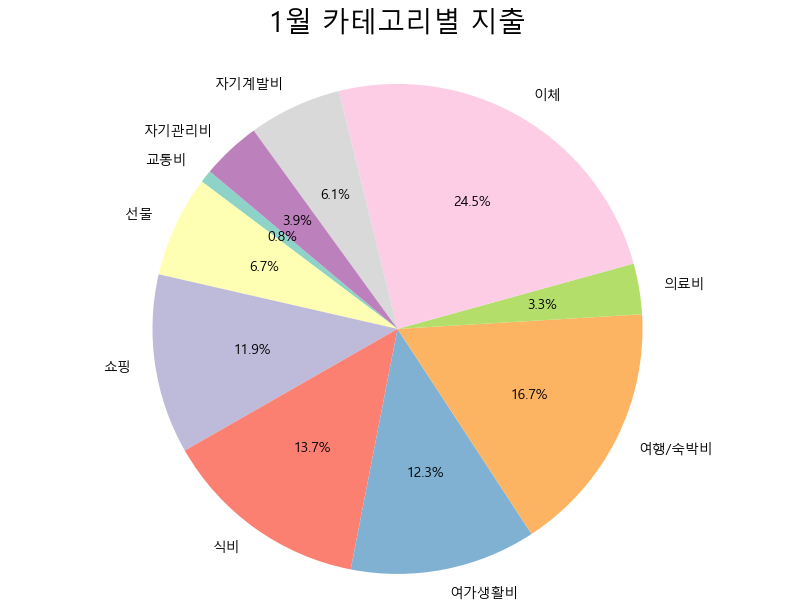

In [84]:
# 월 정보 추출
target_month = pd.to_datetime(df_final['expenditure_date']).iloc[0].month

# 파이 차트 생성
plt.figure(figsize=(10, 7))
if not df_pie.empty:
    plt.pie(df_pie['total_amount'], 
            labels=df_pie['category_name'], 
            autopct='%1.1f%%', # 소수점 첫째 자리까지 표시
            startangle=140,    # 그래프 시작 각도 설정
            colors=plt.cm.Set3.colors)
    plt.title(f'{target_month}월 카테고리별 지출', fontsize=20, pad=20)
    plt.axis('equal')  # 비율 조정
    plt.show()
else:
    print("데이터를 삽입하세요.")

## 2.2. 주별 지출 추이

In [66]:
# 주별 소비 합계 계산
query = """
SELECT DATE_FORMAT(expenditure_date, '%%Y-%%u주') as week, SUM(expenditure_amount) as total_amount
FROM expenditure
GROUP BY week
ORDER BY week;
"""

df_weekly = pd.read_sql(query, engine)

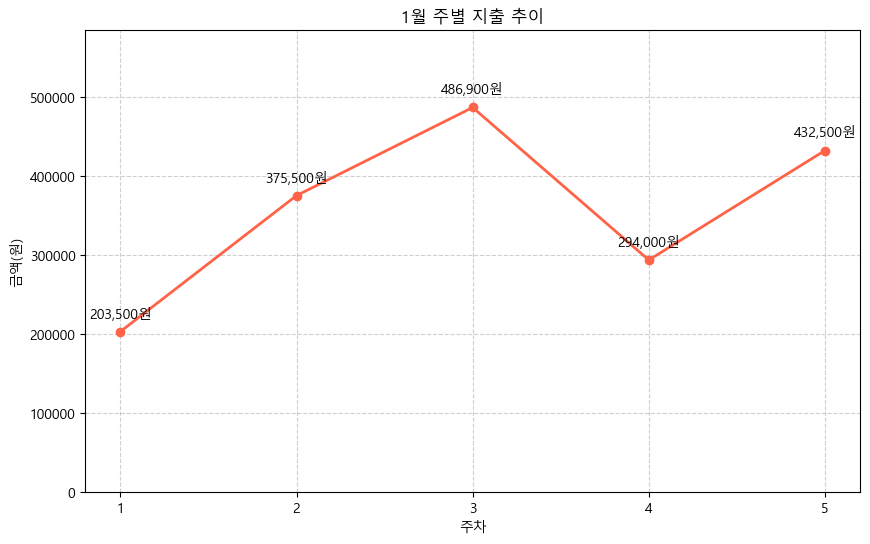

In [88]:
# 월 정보 추출
target_month = pd.to_datetime(df_final['expenditure_date']).iloc[0].month

# 선 그래프 생성
x_axis = list(range(1, len(df_weekly) + 1)) # X축 설정
plt.figure(figsize=(10, 6))
plt.plot(x_axis, df_weekly['total_amount'], marker='o', color='tomato', linewidth=2)

# Y축 여유 공간 설정
max_val = df_weekly['total_amount'].max()
plt.ylim(0, max_val * 1.2)

plt.title(f'{target_month}월 주별 지출 추이')
plt.xlabel('주차')
plt.ylabel('금액(원)')
plt.xticks(x_axis) # X축 눈금 정수로 고정
plt.grid(True, linestyle='--', alpha=0.6) #배경에 점선 추가

for i, txt in enumerate(df_weekly['total_amount']):  # 각 점 위에 금액 표시
    plt.annotate(f'{int(txt):,}원', (x_axis[i], df_weekly['total_amount'][i]), 
    textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

## 2.3. 일별 소비 히트맵

In [128]:
# 일별 소비 합계 계산
query = """
SELECT expenditure_date, SUM(expenditure_amount) as daily_total 
FROM expenditure 
GROUP BY expenditure_date;
"""

df = pd.read_sql(query, engine)

In [129]:
# 날짜 정보 추출
df['expenditure_date'] = pd.to_datetime(df['expenditure_date'])
year = df['expenditure_date'].dt.year.iloc[0]
month = df['expenditure_date'].dt.month.iloc[0]
df['day'] = df['expenditure_date'].dt.day 
df['weekday'] = df['expenditure_date'].dt.weekday 

# 특정 연도와 월의 시작 요일 찾음
first_weekday = calendar.monthrange(year, month)[0]

# 데이터가 없는 날을 0원으로 채움
all_days = pd.DataFrame({'day': range(1, 32)})
df_full = pd.merge(all_days, df, left_on='day', right_on='df.expenditure_date.dt.day' 
                   if False else 'day', how='left').fillna(0)

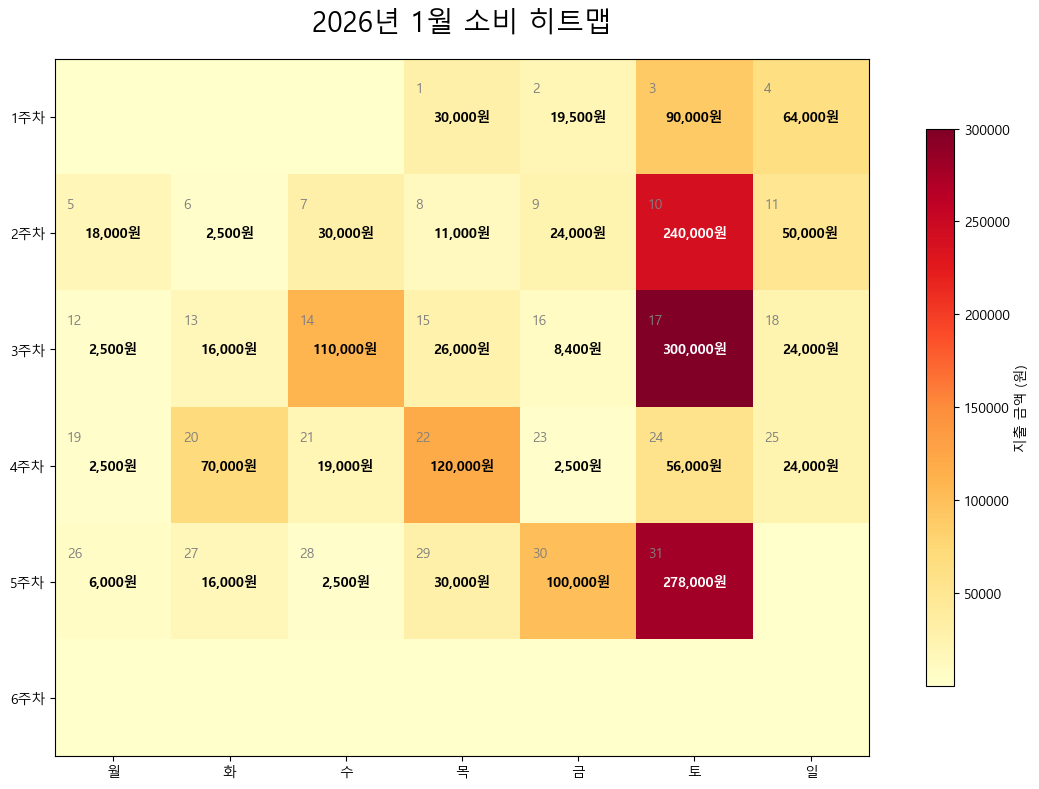

In [131]:
calendar_grid = np.zeros((6, 7))
day_labels = np.zeros((6, 7))

# 위치에 맞게 금액 및 날짜 배치
for d in range(1, 32):
    day_data = df_full[df_full['day'] == d]
    amount = day_data['daily_total'].values[0] if not day_data.empty else 0

    # 달력 좌표 계산
    idx = d + first_weekday - 1
    row = idx // 7
    col = idx % 7

    # 지출 금액 저장
    if row < 6:
        calendar_grid[row, col] = amount
        day_labels[row, col] = d

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(calendar_grid, cmap='YlOrRd', vmin=1, aspect='equal') 

ax.set_xticks(np.arange(7))
ax.set_xticklabels(['월', '화', '수', '목', '금', '토', '일'])
ax.set_yticks(np.arange(6))
ax.set_yticklabels([f'{i+1}주차' for i in range(6)])

# 히트맵 위에 텍스트(날짜, 금액) 표시
for i in range(6):
    for j in range(7):
        day_num = int(day_labels[i, j])
        if day_num > 0:  # 날짜가 있는 칸만 작성
            ax.text(j-0.4, i-0.3, str(day_num), va='top', ha='left', fontsize=10, color='gray')
            amount = calendar_grid[i, j]
            if amount > 0:  # 돈을 쓴 날만 금액 표시
                color = 'white' if amount > calendar_grid.max() * 0.6 else 'black'
                ax.text(j, i, f'{int(amount):,}원', ha='center', va='center', fontweight='bold', color=color)

plt.colorbar(im, label='지출 금액 (원)', shrink=0.8)
plt.title(f'{year}년 {month}월 소비 히트맵', fontsize=20, pad=20)
plt.tight_layout()
plt.show()

# **3. 소비 목표 관리**

In [191]:
# 목표 예산
target_budget = 400000

# 전체 지출 합계 계산
query = "SELECT SUM(expenditure_amount) as total FROM expenditure"
df_total = pd.read_sql(query, engine)

# 금액 추출 (지출이 없는 경우 0저장)
current_spend = df_total['total'].iloc[0] if df_total['total'].iloc[0] else 0

# 날짜 정보 추출
target_date = pd.to_datetime(df['expenditure_date']).iloc[0]
year, month = target_date.year, target_date.month

In [192]:
print(f"--- {year}년 {month}월 소비 리포트 ---")
print(f" 목표 예산: {target_budget:,}원")
print(f" 총 지출액: {int(current_spend):,}원")

# 목표 예산 초과한 경우
if current_spend > target_budget: 
    over_amount = current_spend - target_budget  # 초과금액
    over_ratio = (over_amount / target_budget) * 100  # 초과 비율
    
    print(f"\n 🚨 [경고] 목표 예산을 초과했습니다!")
    print(f" 초과 금액: {int(over_amount):,}원")
    print(f" 초과 비율: {over_ratio:.2f}%")

# 목표 예산을 초과하지 않은 경우
else:  
    remaining_budget = target_budget - current_spend # 남은 금액
    spend_ratio = (current_spend / target_budget) * 100 # 예산 사용률
    
    print(f" 남은 여유 자금: {int(remaining_budget):,}원")
    print(f" 예산 사용률: {spend_ratio:.1f}%")

--- 2026년 1월 소비 리포트 ---
 목표 예산: 400,000원
 총 지출액: 1,792,400원

 🚨 [경고] 목표 예산을 초과했습니다!
 초과 금액: 1,392,400원
 초과 비율: 348.10%


# **4. 소비 예측**

In [185]:
# 데이터셋 파일 읽기
file_name2='sample_dataset_2.csv'
df_now=pd.read_csv(file_name2, encoding='utf-8-sig')

In [201]:
# 현재까지의 지출 합계 계산
spend_now = df_now['amount'].sum()

# 날짜 정보 추출
df_now['date'] = pd.to_datetime(df_now['date'])
today = df_now['date'].max()  # 데이터 내 가장 최신 날짜를 오늘로 지정
curr_year = today.year
curr_month = today.month
curr_day = today.day

# 해당 월의 총 일수
_, last_day = calendar.monthrange(curr_year, curr_month)

# 소비 예측 계산
daily_avg = spend_now / curr_day # 일평균
predicted_total = daily_avg * last_day # 예상 총 지출

# 목표 예산
target_budget = 400000

In [202]:
# 소비 예측
print(f"--- {curr_year}년 {curr_month}월 소비 예측 ---")
print(f" 목표 예산: {target_budget:,}원")
print(f" 현재까지 누적 지출: {int(spend_now):,}원")
print(f" 월말 예상 총 지출: {int(predicted_total):,}원")

# 예상 총 지출이 목표 예산을 초과하는 경우
if predicted_total > target_budget:  
    over_amount = predicted_total - target_budget
    print(f"\n 🚨 [경고] 목표 예산을 약 {int(over_amount):,}원 초과할 것으로 예상됩니다!")
    
    # 남은 기간 하루 권장 지출액 계산
    remaining_days = last_day - curr_day # 남은 날짜 계산
    safe_daily = (target_budget - spend_now) / remaining_days if remaining_days > 0 else 0
    print(f" 하루 권장 지출액: {int(safe_daily):,}원")

# 예상 총 지출이 목표 예산을 초과하지 않는 경우
else:
    print(f"\n ✅ 목표 예산을 초과하지 않을 것으로 예상됩니다.")

--- 2026년 2월 소비 예측 ---
 목표 예산: 400,000원
 현재까지 누적 지출: 381,500원
 월말 예상 총 지출: 712,133원

 🚨 [경고] 목표 예산을 약 312,133원 초과할 것으로 예상됩니다!
 하루 권장 지출액: 1,423원
